In [278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.regression.linear_model import RegressionResults

In [262]:
# turns a ascii raster file into a list of values

def raster_to_list(filename):
    data_list = []
    with open(filename, 'r') as fn:   
        for line in fn:
            try:
                float(line[0])  # see if the line represents data
                line_list = line.rstrip().split(' ')  # reformat line string
                for value in line_list:
                    data_list.append(float(value))
            except:
                continue 
    return data_list

In [263]:
# convert the relevant rasters

model_output = raster_to_list('ABM_Output_Mean.asc')
observations = raster_to_list('cov_density.asc')
parcels = raster_to_list('parcels_1910/parcels_1910.asc')
water_distance = raster_to_list('DistToWater/disttowater.asc')

In [264]:
# turn the raster data into a table.  Each relevant pixel is a row

data_tuples = list(zip(range(len(model_list)), model_output, observations, parcels, water_distance))
df = pd.DataFrame(data_tuples, columns=['ID', 'model', 'observation', 'parcel', 'water_distance'])

# only include pixels that were undeveloped at the start of the model run and that aren't water
# we know those won't have covenants
df = df.loc[(df['parcel'] == 0) & (df['water_distance'] > 0)]

# check the head of the dataframe to confirm it looks correcnt
df.head(20)

,ID,model,observation,parcel,water_distance
0,0,0.40,16.232340,0.0,707.1068
1,1,0.40,16.802630,0.0,559.0170
2,2,0.50,13.638120,0.0,500.0000
3,3,0.65,7.629796,0.0,500.0000
4,4,0.25,2.428696,0.0,353.5534
5,5,0.25,2.482192,0.0,250.0000
6,6,0.30,6.586835,0.0,250.0000
9,9,0.85,72.907680,0.0,250.0000
10,10,0.60,89.301530,0.0,353.5534
11,11,0.40,82.672070,0.0,559.0170


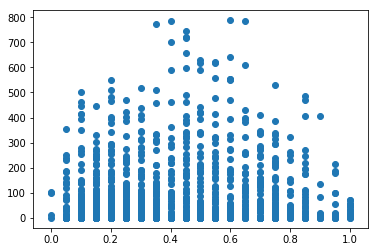

In [275]:
# display a scatter plot of the relationship between the modeled output and observation data
# If the model is good, there should be a positive correlation
plt.scatter(df['model'], df['observation'])

In [276]:
# create a linear regression model of the relationship between the predicted and observed values

# data from dataframe
X = df['model'].values.reshape(-1, 1)
y = df['observation'].values.reshape(-1, 1)

# stats model needs a constant to create an intercept
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     20.12
Date:                Sat, 30 Nov 2019   Prob (F-statistic):           7.92e-06
Time:                        10:06:05   Log-Likelihood:                -8200.6
No. Observations:                1299   AIC:                         1.641e+04
Df Residuals:                    1297   BIC:                         1.642e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         63.3590      6.970      9.091      0.0

In [287]:
residualsdf = pd.DataFrame({'ID': df['ID'], 'Residual': results.resid})
residualsdf.head(20)

,ID,Residual
0,0,-74.400834
1,1,-73.830544
2,2,-83.813601
3,3,-100.049745
4,4,-77.976658
5,5,-77.923162
6,6,-77.227793
9,9,-48.408955
10,10,-14.968738
11,11,-7.961104


In [288]:
# turn the residuals table into an ascii raster 
# Import into ArcGIS to check if they are spatially autocorrelated

with open('residuals.asc', 'w') as residuals:
    residuals.write(
        "ncols         41\nnrows         70\nxllcorner     473979.5318\nyllcorner     4970867.4064\ncellsize      250\nNODATA_value  -9999\n"
        )
    for i in range(len(model_output)):
        try:
            residuals.write(str(residualsdf.loc[i]['Residual']))
        except:
            residuals.write('0')
        if i % 41 == 40:
            residuals.write('\n')
        else:
            residuals.write(' ')